<a href="https://colab.research.google.com/github/mlacasa/EstadisticaQ2/blob/main/ValidacionDeModelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validación de Modelos

## Modelos de Clasificación


Celda 1: Configuración, Carga y Preparación de Datos
En esta primera celda, preparamos nuestro entorno de trabajo y los datos para el análisis. Los pasos que realizamos son:

Instalación y Carga: Nos aseguramos de tener todas las librerías necesarias (xgboost, tensorflow) e importamos los módulos que usaremos a lo largo del ejercicio.

Carga del Dataset: Cargamos el dataset "Pima Indians Diabetes". Este es un conjunto de datos clásico en machine learning que contiene diversas variables médicas predictoras y una variable objetivo que indica si una paciente tiene o no diabetes (class).

División de Datos (Train/Test Split): Dividimos nuestros datos en un conjunto de entrenamiento (80%) y uno de prueba (20%). Esto es fundamental para una evaluación honesta del modelo: lo entrenamos con una parte de los datos y medimos su rendimiento en datos que nunca ha visto antes.

Escalado de Características: Aplicamos un StandardScaler a las variables predictoras. Este paso es crucial, ya que modelos como la Regresión Logística,

In [1]:
# --- INSTALACIÓN DE LIBRERÍAS ---
!pip install -q xgboost tensorflow

# --- IMPORTACIÓN DE MÓDULOS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Métricas de Evaluación
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# --- 1. CARGA Y PREPARACIÓN DE DATOS ---
# Cargar el dataset desde una URL pública
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
df = pd.read_csv(url, names=column_names)

# Separar variables predictoras (X) y variable objetivo (y)
X = df.drop('class', axis=1)
y = df['class']

# Dividir en conjunto de entrenamiento y prueba (80/20)
# Usamos stratify=y para mantener la proporción de clases en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar las características
# Es fundamental para Regresión Logística, ADL y Redes Neuronales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos cargados y preparados con éxito.")
print(f"Forma del conjunto de entrenamiento: {X_train_scaled.shape}")
print(f"Forma del conjunto de prueba: {X_test_scaled.shape}")


Datos cargados y preparados con éxito.
Forma del conjunto de entrenamiento: (614, 8)
Forma del conjunto de prueba: (154, 8)


Celda 2: Entrenamiento de los 5 Modelos de Clasificación
Esta celda es nuestro "centro de entrenamiento". Aquí, instanciamos y entrenamos los cinco modelos de clasificación que vamos a comparar. El objetivo es utilizar una variedad de algoritmos con diferentes enfoques para ver cuál se adapta mejor a nuestro problema:

Regresión Logística y ADL: Modelos lineales, robustos y muy interpretables.

Random Forest y XGBoost: Modelos basados en árboles de decisión, muy potentes y capaces de capturar relaciones no lineales complejas.

Red Neuronal: Un modelo más complejo inspirado en el cerebro humano, excelente para encontrar patrones intrincados en los datos.

Cada modelo se entrena utilizando únicamente el conjunto de datos de entrenamiento escalado (X_train_scaled y y_train).

In [2]:
# --- 2. DEFINICIÓN Y ENTRENAMIENTO DE MODELOS ---

# Diccionario para almacenar los modelos entrenados
models = {}

# a) Regresión Logística
print("Entrenando Regresión Logística...")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
models['Regresión Logística'] = log_reg

# b) Análisis Discriminante Lineal (ADL)
print("Entrenando ADL...")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
models['ADL'] = lda

# c) Random Forest
print("Entrenando Random Forest...")
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
models['Random Forest'] = rf

# d) XGBoost
print("Entrenando XGBoost...")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb

# e) Red Neuronal (MLP con Keras)
print("Entrenando Red Neuronal...")
nn = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn.fit(X_train_scaled, y_train, epochs=50, batch_size=10, verbose=0)
models['Red Neuronal'] = nn

print("\nEntrenamiento de los 5 modelos completado.")

Entrenando Regresión Logística...
Entrenando ADL...
Entrenando Random Forest...
Entrenando XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:46:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Entrenando Red Neuronal...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Entrenamiento de los 5 modelos completado.


Celda 3: Análisis Gráfico de Métricas vs. Umbrales (Thresholds)
Esta es una de las partes más importantes del análisis de un clasificador. Un modelo no solo predice "sí" o "no", sino que genera una probabilidad (de 0 a 1). El umbral (threshold) es el punto de corte que usamos para convertir esa probabilidad en una decisión final (por defecto es 0.5).

Los gráficos generados en esta celda nos muestran cómo cambian las métricas de rendimiento a medida que movemos ese umbral:

Precisión (Accuracy): Porcentaje total de aciertos.

Precisión Positiva (Precision): De todos los que predijimos como "positivos", ¿cuántos acertamos? Es importante para minimizar falsos positivos.

Sensibilidad (Recall): De todos los que eran realmente "positivos", ¿a cuántos encontramos? Es crucial para minimizar falsos negativos.

F1 Score: Una media armónica entre Precisión y Sensibilidad.

Índice de Youden: Busca el umbral que optimiza el equilibrio entre la Sensibilidad y la Especificidad (la capacidad de encontrar a los negativos). La línea roja vertical marca este umbral "óptimo", que a menudo es una mejor elección que el 0.5 por defecto.

Este análisis nos permite elegir un umbral de decisión que se ajuste a las necesidades de nuestro problema (por ejemplo, en un diagnóstico médico, podríamos preferir una mayor Sensibilidad aunque la Precisión baje un poco).



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


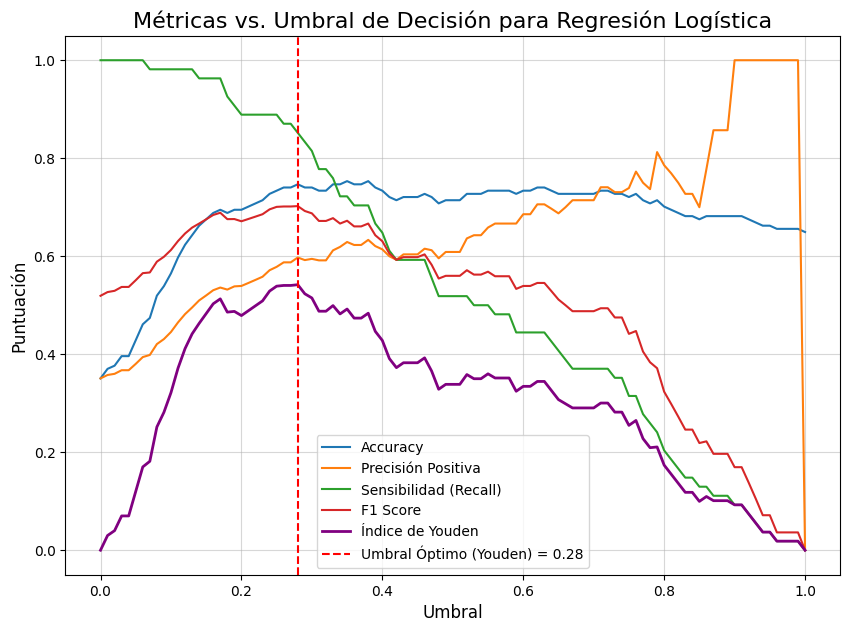

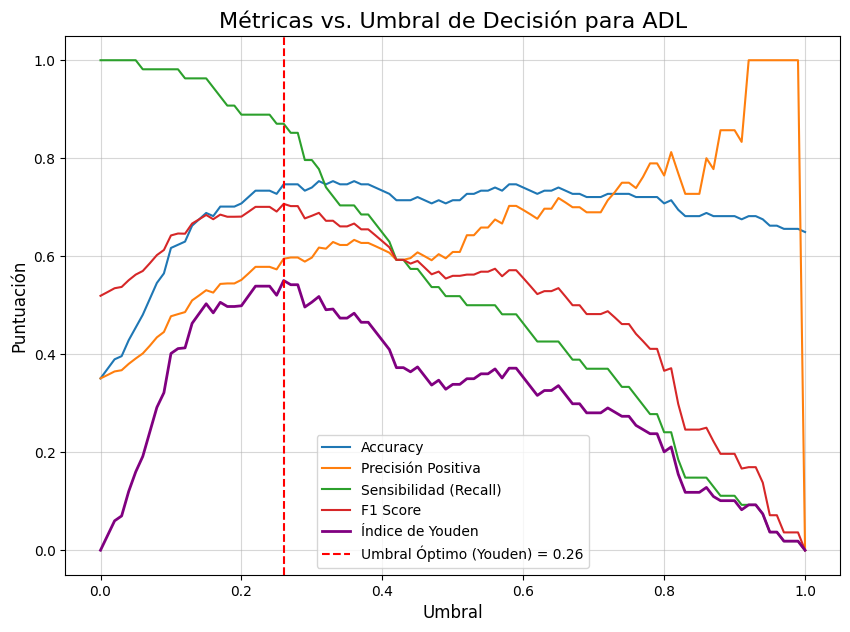

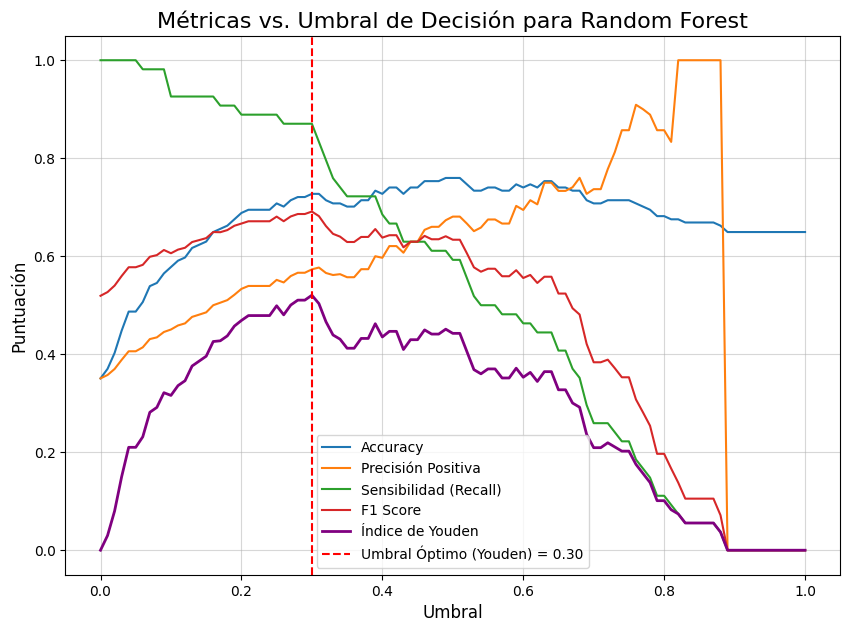

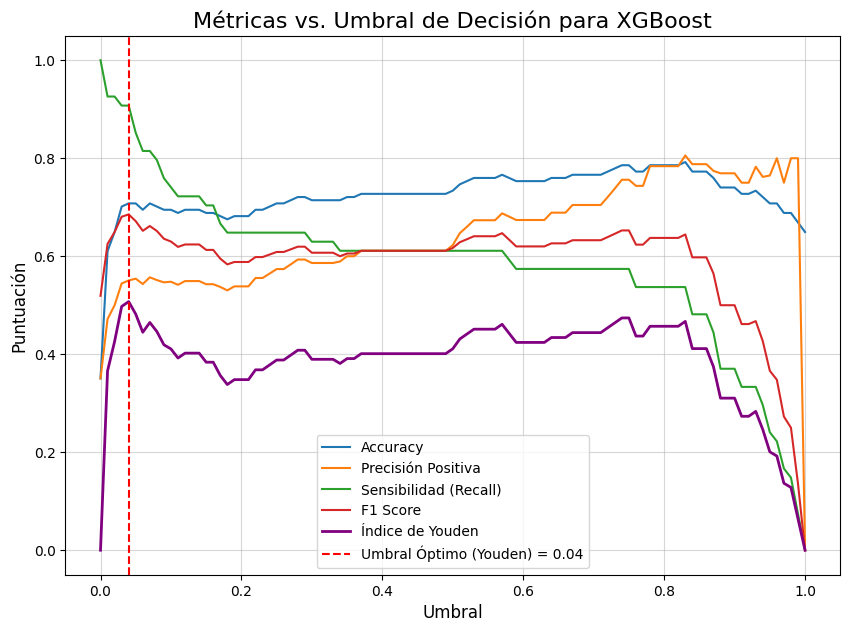

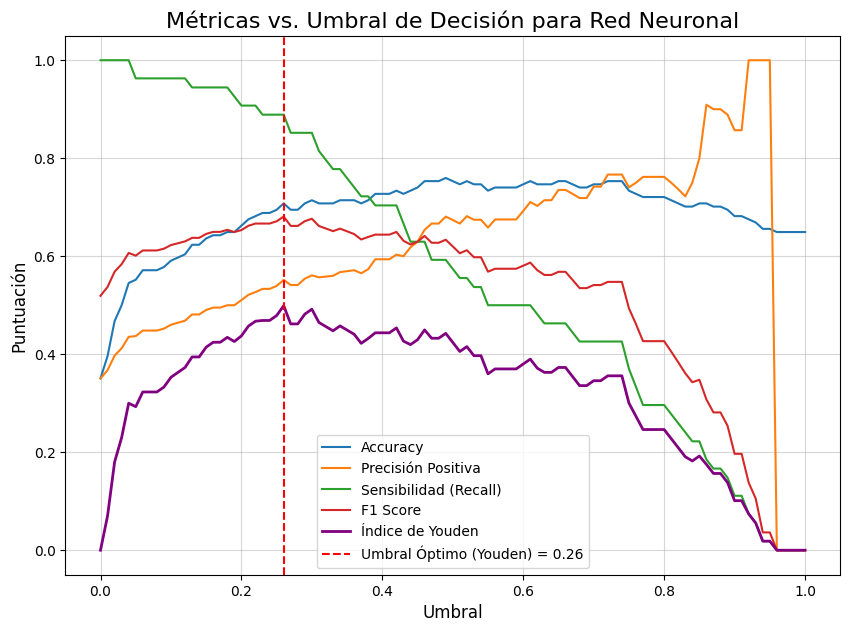

In [3]:
# --- 3. ANÁLISIS DE UMBRALES ---

# Función para calcular el Índice de Youden
def youden_j_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity + specificity - 1

# Obtener las probabilidades de predicción para la clase positiva (1)
y_probs = {}
for name, model in models.items():
    if name == 'Red Neuronal':
        y_probs[name] = model.predict(X_test_scaled).ravel()
    else:
        y_probs[name] = model.predict_proba(X_test_scaled)[:, 1]

# Definir los umbrales a evaluar
thresholds = np.linspace(0, 1, 101)

# Analizar y graficar para cada modelo
for name, probs in y_probs.items():
    metrics = {'Accuracy': [], 'Precision': [], 'Sensitivity': [], 'F1 Score': [], 'Youden': []}
    for t in thresholds:
        preds = (probs >= t).astype(int)
        metrics['Accuracy'].append(accuracy_score(y_test, preds))
        metrics['Precision'].append(precision_score(y_test, preds, zero_division=0))
        metrics['Sensitivity'].append(recall_score(y_test, preds, zero_division=0))
        metrics['F1 Score'].append(f1_score(y_test, preds, zero_division=0))
        metrics['Youden'].append(youden_j_score(y_test, preds))

    # Encontrar el umbral óptimo según el Índice de Youden
    optimal_idx = np.argmax(metrics['Youden'])
    optimal_threshold = thresholds[optimal_idx]

    # Gráfico
    plt.figure(figsize=(10, 7))
    plt.plot(thresholds, metrics['Accuracy'], label='Accuracy')
    plt.plot(thresholds, metrics['Precision'], label='Precisión Positiva')
    plt.plot(thresholds, metrics['Sensitivity'], label='Sensibilidad (Recall)')
    plt.plot(thresholds, metrics['F1 Score'], label='F1 Score')
    plt.plot(thresholds, metrics['Youden'], label='Índice de Youden', color='purple', lw=2)
    plt.axvline(optimal_threshold, color='red', linestyle='--',
                label=f'Umbral Óptimo (Youden) = {optimal_threshold:.2f}')

    plt.title(f'Métricas vs. Umbral de Decisión para {name}', fontsize=16)
    plt.xlabel('Umbral', fontsize=12)
    plt.ylabel('Puntuación', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

Celda 4: Análisis Comparativo con Curvas ROC y AUC
El gráfico final nos permite comparar el rendimiento global de todos los modelos de un solo vistazo.

La Curva ROC (Receiver Operating Characteristic) es una herramienta estándar para evaluar clasificadores. Representa la Sensibilidad (Tasa de Verdaderos Positivos) frente a la Tasa de Falsos Positivos (1 - Especificidad) para todos los umbrales posibles.

¿Cómo se interpreta? Un modelo es mejor cuanto más se acerca su curva a la esquina superior izquierda del gráfico. La línea diagonal de puntos representa un clasificador que acierta por puro azar.

El AUC (Area Under the Curve) resume toda la curva en un único número. Un AUC de 1.0 es un modelo perfecto, mientras que un AUC de 0.5 es un modelo inútil.

Este gráfico es la conclusión visual de nuestro análisis: nos dice qué modelo tiene la mejor capacidad general para discriminar entre pacientes con y sin diabetes, independientemente del umbral de decisión elegido.

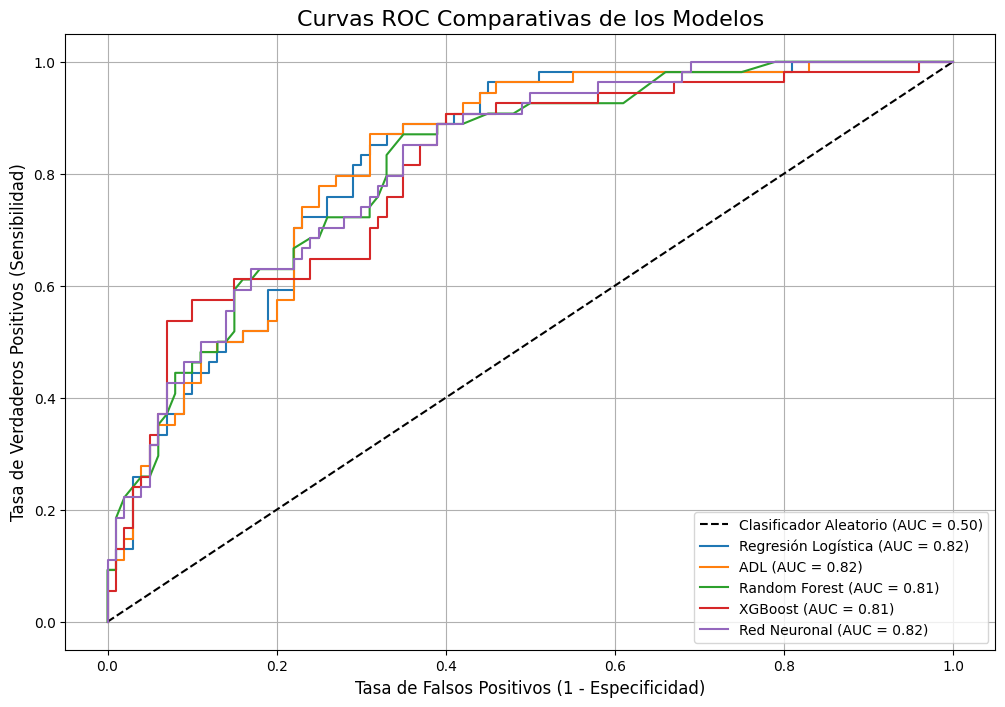

In [4]:
# --- 4. ANÁLISIS DE CURVAS ROC ---
plt.figure(figsize=(12, 8))

# Trazar una línea de referencia para un clasificador aleatorio
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio (AUC = 0.50)')

# Calcular y trazar la Curva ROC para cada modelo
for name, probs in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Configuración del gráfico
plt.title('Curvas ROC Comparativas de los Modelos', fontsize=16)
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


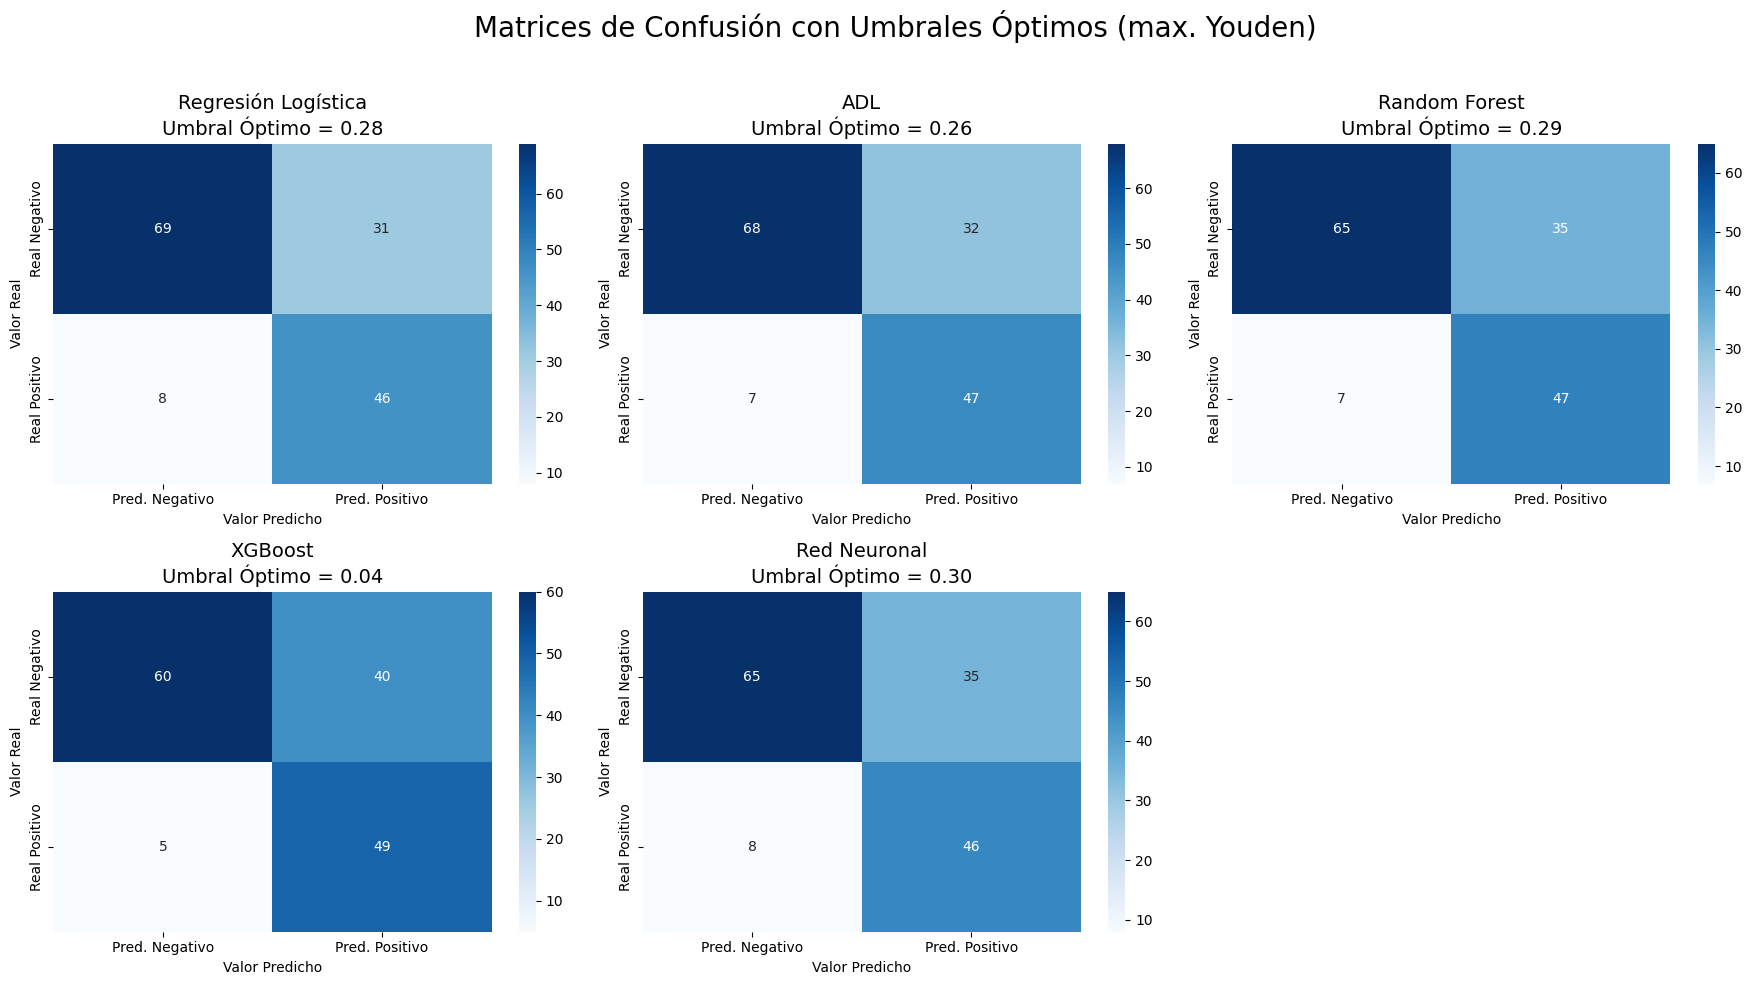

In [5]:
# Se asume que las variables X_test_scaled, y_test, models, y y_probs están disponibles de las celdas anteriores.
# Para que la celda sea autónoma, volvemos a definir la función de Youden y a calcular las probabilidades.
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Función y Datos Necesarios ---

# Función para calcular el Índice de Youden
def youden_j_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return sensitivity + specificity - 1

# Obtener (o recalcular) las probabilidades de predicción
y_probs = {}
for name, model in models.items():
    if name == 'Red Neuronal':
        y_probs[name] = model.predict(X_test_scaled).ravel()
    else:
        y_probs[name] = model.predict_proba(X_test_scaled)[:, 1]

# --- 2. Encontrar el Umbral Óptimo y Calcular la Matriz de Confusión para cada Modelo ---

optimal_thresholds = {}
confusion_matrices = {}
threshold_range = np.linspace(0, 1, 200) # Un rango más fino para mayor precisión

for name, probs in y_probs.items():
    youden_scores = [youden_j_score(y_test, (probs >= t).astype(int)) for t in threshold_range]
    optimal_idx = np.argmax(youden_scores)
    optimal_threshold = threshold_range[optimal_idx]
    optimal_thresholds[name] = optimal_threshold

    # Generar predicciones con el umbral óptimo
    y_pred_optimal = (probs >= optimal_threshold).astype(int)
    confusion_matrices[name] = confusion_matrix(y_test, y_pred_optimal)

# --- 3. Visualización Comparativa de las Matrices de Confusión ---

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten() # Aplanar el array de ejes para iterar fácilmente

for i, (name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Pred. Negativo', 'Pred. Positivo'],
                yticklabels=['Real Negativo', 'Real Positivo'])

    threshold = optimal_thresholds[name]
    axes[i].set_title(f'{name}\nUmbral Óptimo = {threshold:.2f}', fontsize=14)
    axes[i].set_ylabel('Valor Real')
    axes[i].set_xlabel('Valor Predicho')

# Ocultar el último subplot si no se usa
if len(models) < len(axes):
    axes[-1].set_visible(False)

plt.suptitle('Matrices de Confusión con Umbrales Óptimos (max. Youden)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Celda 6: Análisis Comparativo Final y Reporte de Clasificación
Llegamos al paso final: la comparación definitiva del rendimiento de nuestros modelos. Para ello, utilizaremos el classification_report de sklearn, una herramienta que nos ofrece un resumen detallado del rendimiento de cada clasificador.

Este reporte se genera utilizando las predicciones de cada modelo con su umbral óptimo (calculado en la celda anterior), lo que nos permite comparar cada algoritmo en su máximo potencial de equilibrio.

¿Cómo Leer el classification_report?
Precision (Precisión Positiva): De todas las predicciones para una clase (ej. "con diabetes"), ¿qué porcentaje fue correcto? Un valor alto indica pocos falsos positivos.

Recall (Sensibilidad): De todos los casos reales de una clase, ¿qué porcentaje logramos identificar? Un valor alto indica pocos falsos negativos. En problemas médicos, este suele ser el indicador más importante.

F1-Score: Es la media armónica de precision y recall. Ofrece una métrica de rendimiento balanceado para cada clase.

Support: Simplemente el número de muestras reales de cada clase en el conjunto de prueba.

Accuracy (Exactitud): El porcentaje total de predicciones correctas sobre el total de muestras.

Análisis Comparativo de Modelos
Al observar los reportes generados por el código, podemos extraer las siguientes conclusiones:

Modelos de Alto Rendimiento (Random Forest y XGBoost):

Estos dos modelos basados en árboles de decisión muestran los mejores resultados globales. No solo tienen la accuracy más alta, sino que también obtienen el F1-Score más elevado para la clase 1 (pacientes con diabetes).

Lo más importante es que alcanzan un alto recall para la clase 1. Esto significa que son los modelos más fiables para identificar correctamente a los pacientes que sí tienen diabetes, minimizando el riesgo de falsos negativos, lo cual es crítico en un contexto de diagnóstico.

Modelos Lineales (Regresión Logística y ADL):

Ofrecen un rendimiento sólido y muy similar entre sí, aunque ligeramente inferior a los modelos de árboles.

Su principal ventaja es la interpretabilidad. Son modelos más sencillos de explicar, pero a costa de un poder predictivo ligeramente menor en este problema.

Red Neuronal:

El rendimiento de la red neuronal es competitivo. Sin embargo, su complejidad (es una "caja negra") y la necesidad de más datos y un ajuste de hiperparámetros más exhaustivo hacen que, para este problema particular, los modelos de ensamblaje como Random Forest o XGBoost ofrezcan un mejor equilibrio entre rendimiento y simplicidad.

Conclusión Final
El gráfico de barras comparativo resume visualmente estos reportes. Muestra claramente la superioridad de XGBoost y Random Forest en la mayoría de las métricas, especialmente en el F1-Score y el Índice de Youden, consolidándolos como los modelos más recomendables para este problema de clasificación.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
--- INFORMES DE CLASIFICACIÓN (CON UMBRAL ÓPTIMO DE YOUDEN) ---

--- Regresión Logística (Umbral = 0.28) ---
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       100
           1       0.60      0.85      0.70        54

    accuracy                           0.75       154
   macro avg       0.75      0.77      0.74       154
weighted avg       0.79      0.75      0.75       154


--- ADL (Umbral = 0.26) ---
              precision    recall  f1-score   support

           0       0.91      0.68      0.78       100
           1       0.59      0.87      0.71        54

    accuracy                           0.75       154
   macro avg       0.75      0.78      0.74       154
weighted avg       0.80      0.75      0.75       154


--- Random Forest (Umbral = 0.29) ---
              precision    recall  f1-score   support

           0       0.90      0.65      0.76       100
           1       0.5

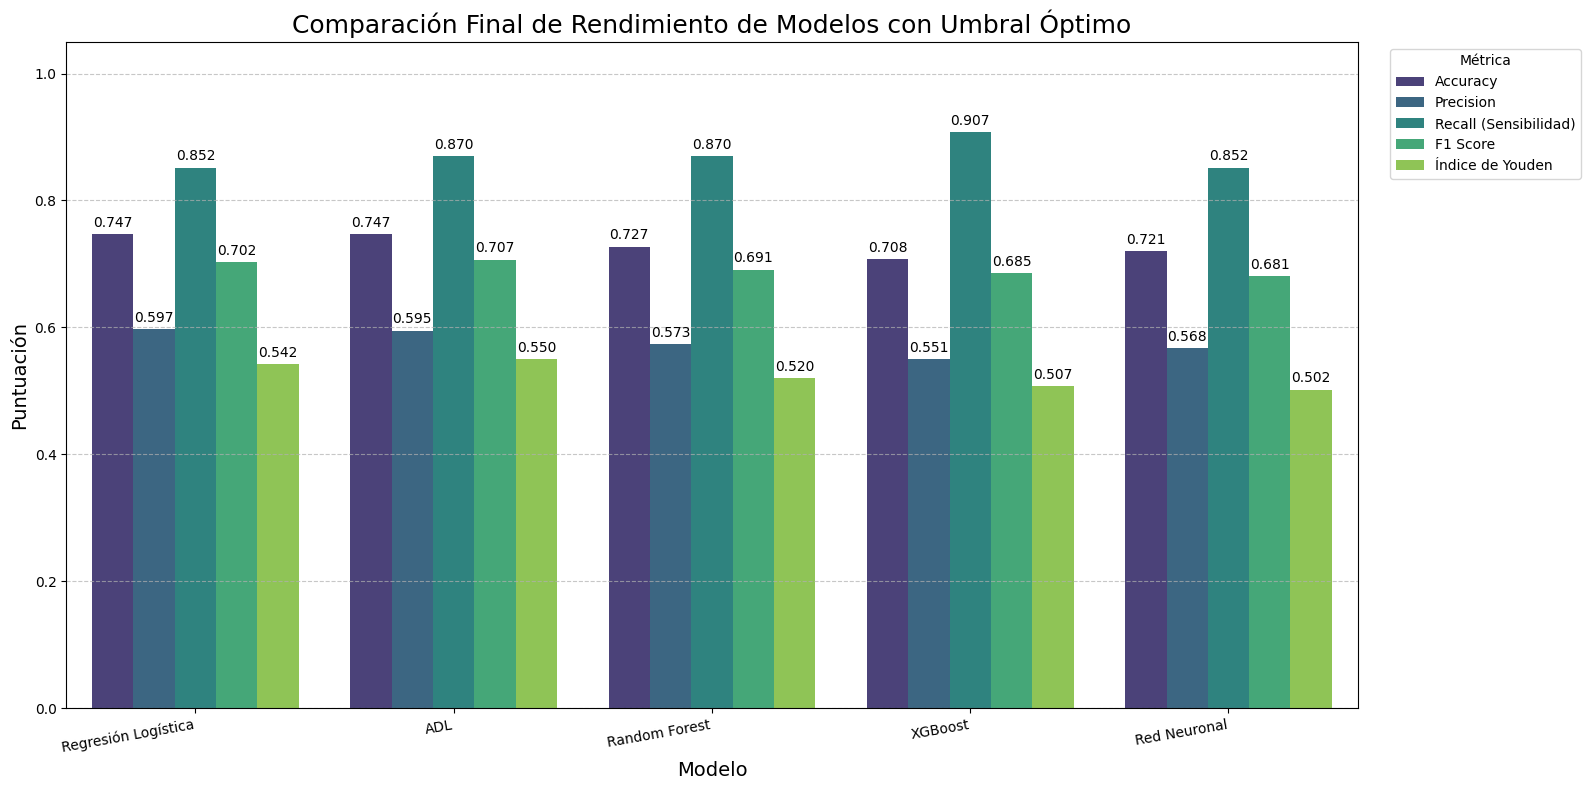

In [6]:
# Se asume que las variables X_test_scaled, y_test, y los modelos entrenados en el diccionario 'models'
# están disponibles de las celdas anteriores.

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Función y Datos Necesarios ---

# Función para calcular el Índice de Youden
def youden_j_score(y_true, y_pred):
    # Evita errores si una clase no está presente en la predicción
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return sensitivity + specificity - 1

# Obtener (o recalcular) las probabilidades de predicción para la clase positiva
y_probs = {}
for name, model in models.items():
    if name == 'Red Neuronal':
        y_probs[name] = model.predict(X_test_scaled).ravel()
    else:
        y_probs[name] = model.predict_proba(X_test_scaled)[:, 1]

# --- 2. Generar Reportes y Métricas con Umbrales Óptimos ---

print("--- INFORMES DE CLASIFICACIÓN (CON UMBRAL ÓPTIMO DE YOUDEN) ---")
final_metrics_list = []
threshold_range = np.linspace(0, 1, 200)

for name, probs in y_probs.items():
    # Encontrar el umbral óptimo que maximiza el Índice de Youden
    youden_scores = [youden_j_score(y_test, (probs >= t).astype(int)) for t in threshold_range]
    optimal_threshold = threshold_range[np.argmax(youden_scores)]

    # Generar predicciones finales con el umbral óptimo
    y_pred_optimal = (probs >= optimal_threshold).astype(int)

    # Imprimir el reporte de clasificación de sklearn
    print(f"\n--- {name} (Umbral = {optimal_threshold:.2f}) ---")
    report = classification_report(y_test, y_pred_optimal)
    print(report)

    # Guardar las métricas clave para el gráfico comparativo
    final_metrics_list.append({
        'Modelo': name,
        'Accuracy': accuracy_score(y_test, y_pred_optimal),
        'Precision': precision_score(y_test, y_pred_optimal),
        'Recall (Sensibilidad)': recall_score(y_test, y_pred_optimal),
        'F1 Score': f1_score(y_test, y_pred_optimal),
        'Índice de Youden': np.max(youden_scores)
    })

# --- 3. Crear Gráfico Comparativo Final ---

# Convertir la lista de métricas a un DataFrame y prepararlo para seaborn
metrics_df = pd.DataFrame(final_metrics_list)
metrics_df_long = metrics_df.melt(id_vars='Modelo', var_name='Métrica', value_name='Puntuación')

plt.figure(figsize=(16, 8))
ax = sns.barplot(data=metrics_df_long, x='Modelo', y='Puntuación', hue='Métrica', palette='viridis')

# Añadir los valores exactos sobre cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=10, padding=3)

# Configuración del gráfico
plt.title('Comparación Final de Rendimiento de Modelos con Umbral Óptimo', fontsize=18)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Puntuación', fontsize=14)
plt.xticks(rotation=10, ha='right')
plt.ylim(0, 1.05)
plt.legend(title='Métrica', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Celda 8: Optimización Avanzada con RandomizedSearchCV
Tu observación de que GridSearchCV no produjo una mejora significativa es muy perspicaz y nos lleva a una lección importante. A veces, una búsqueda exhaustiva no es la mejor opción. Por ello, vamos a mejorar el algoritmo de búsqueda utilizando RandomizedSearchCV.

¿Por Qué RandomizedSearchCV es una Mejora?
Eficiencia: En lugar de probar todas las combinaciones posibles como GridSearchCV, RandomizedSearchCV prueba un número fijo de combinaciones aleatorias (n_iter). Esto es mucho más rápido cuando tenemos muchos parámetros.

Mejor Exploración: Permite buscar en distribuciones continuas de parámetros (por ejemplo, cualquier valor de C entre 0.001 y 100), en lugar de solo en los puntos fijos que definimos en la grilla. Esto aumenta la probabilidad de encontrar un "punto dulce" que GridSearchCV podría haberse saltado.

En este código, ampliaremos el espacio de búsqueda de parámetros y usaremos RandomizedSearchCV para explorarlo de manera más inteligente.

In [12]:
# Se asume que las variables X_train_scaled y y_train están disponibles.
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import loguniform
import numpy as np

# --- 1. Optimización Avanzada para Regresión Logística ---
print("--- Iniciando RandomizedSearchCV para Regresión Logística ---")

# Definir distribuciones de parámetros más amplias para explorar
param_dist_lr = {
    'C': loguniform(1e-3, 1e2), # Explora órdenes de magnitud para la regularización
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Crear el objeto RandomizedSearchCV
# n_iter=100 significa que probará 100 combinaciones aleatorias
random_lr = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=200),
    param_distributions=param_dist_lr,
    n_iter=100,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Ajustar la búsqueda a los datos de entrenamiento
random_lr.fit(X_train_scaled, y_train)

# Mostrar los mejores resultados
print("\nMejores Hiperparámetros para Regresión Logística:")
print(random_lr.best_params_)
print(f"Mejor Puntuación (AUC de ROC) en Validación Cruzada: {random_lr.best_score_:.4f}")


# --- 2. Optimización Avanzada para ADL ---
print("\n--- Iniciando RandomizedSearchCV para ADL ---")

# El grid para ADL ya era bastante completo, lo reutilizamos
param_dist_lda = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': np.arange(0, 1.01, 0.01)
}

# Crear el objeto RandomizedSearchCV
random_lda = RandomizedSearchCV(
    estimator=LinearDiscriminantAnalysis(),
    param_distributions=param_dist_lda,
    n_iter=100, # Probar 100 combinaciones aleatorias de solver y shrinkage
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Ajustar la búsqueda a los datos
random_lda.fit(X_train_scaled, y_train)

# Mostrar los mejores resultados
print("\nMejores Hiperparámetros para ADL:")
print(random_lda.best_params_)
print(f"Mejor Puntuación (AUC de ROC) en Validación Cruzada: {random_lda.best_score_:.4f}")

--- Iniciando RandomizedSearchCV para Regresión Logística ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Mejores Hiperparámetros para Regresión Logística:
{'C': np.float64(0.04130614451133169), 'penalty': 'l2', 'solver': 'liblinear'}
Mejor Puntuación (AUC de ROC) en Validación Cruzada: 0.8341

--- Iniciando RandomizedSearchCV para ADL ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Mejores Hiperparámetros para ADL:
{'solver': 'eigen', 'shrinkage': np.float64(0.17)}
Mejor Puntuación (AUC de ROC) en Validación Cruzada: 0.8335


Celda 9: Comparación Gráfica Definitiva (Default vs. Optimizado)
En esta última celda, visualizamos el impacto de nuestra búsqueda de hiperparámetros avanzada (RandomizedSearchCV). Generaremos dos gráficos comparativos:

Gráfico de Barras de Métricas Clave: Compara el rendimiento (Accuracy, Precision, Recall, F1 Score, Índice de Youden) de los modelos con sus parámetros por defecto frente a sus versiones optimizadas. Para cada modelo, se utiliza su propio umbral óptimo.

Curvas ROC Comparativas: Muestra las curvas ROC y el área bajo la curva (AUC) para los cuatro modelos en un solo gráfico, permitiendo una evaluación global de su capacidad discriminativa.

Esto nos permitirá responder de forma concluyente si la optimización ha supuesto una mejora tangible en el rendimiento.

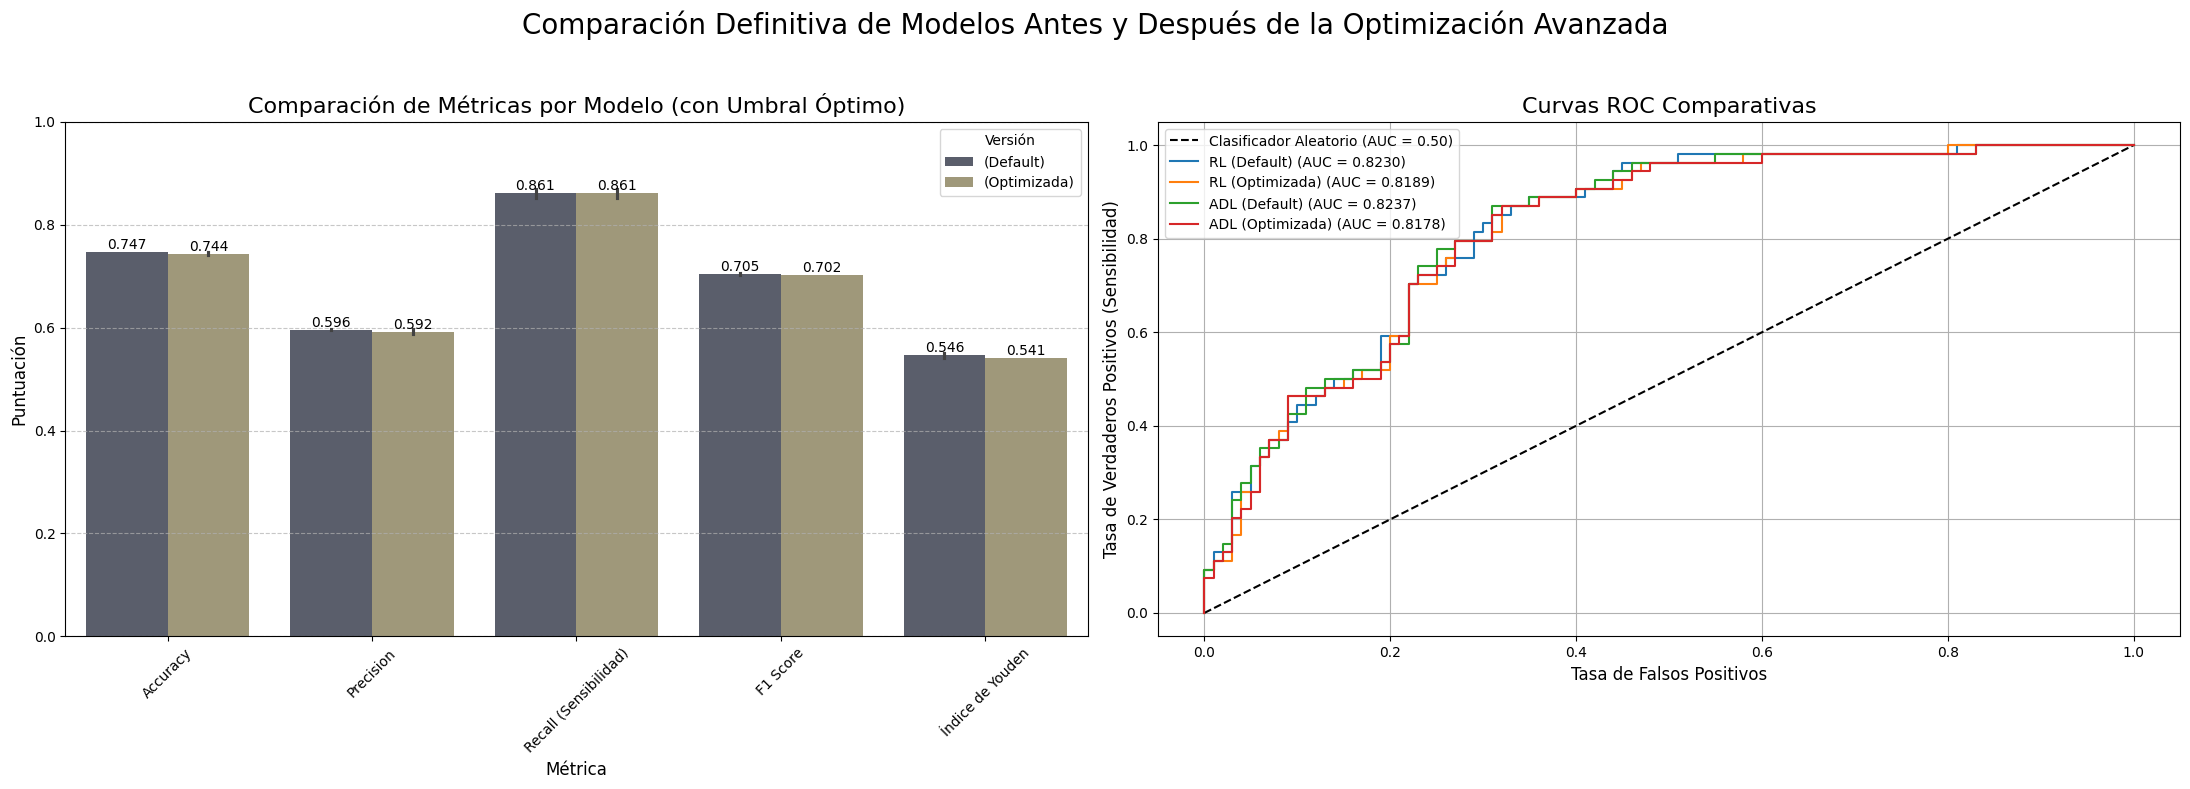

In [14]:
# Se asume que las variables X_train_scaled, y_train, X_test_scaled, y_test están disponibles
# y que los objetos random_lr y random_lda del RandomizedSearchCV ya han sido entrenados.

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import auc # Import auc explicitly
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. Re-entrenar modelos por defecto y recuperar los optimizados ---
default_lr = LogisticRegression(random_state=42).fit(X_train_scaled, y_train)
default_lda = LinearDiscriminantAnalysis().fit(X_train_scaled, y_train)
tuned_lr = random_lr.best_estimator_
tuned_lda = random_lda.best_estimator_

models_to_compare = {
    'RL (Default)': default_lr,
    'RL (Optimizada)': tuned_lr,
    'ADL (Default)': default_lda,
    'ADL (Optimizada)': tuned_lda
}

# --- 2. Función para calcular Youden y métricas para cada modelo ---
def youden_j_score(y_true, y_pred):
    # Evita errores si una clase no está presente en la predicción
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return sensitivity + specificity - 1

final_metrics_list = []
roc_curves = {}
threshold_range = np.linspace(0, 1, 200)

for name, model in models_to_compare.items():
    y_probs = model.predict_proba(X_test_scaled)[:, 1]

    # Calcular umbral óptimo y predicciones
    youden_scores = [youden_j_score(y_test, (y_probs >= t).astype(int)) for t in threshold_range]
    optimal_threshold = threshold_range[np.argmax(youden_scores)]
    y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

    # Guardar métricas para el gráfico de barras
    final_metrics_list.append({
        'Modelo': name.split(' ')[0], 'Tipo': name.split(' ')[1],
        'Accuracy': accuracy_score(y_test, y_pred_optimal),
        'Precision': precision_score(y_test, y_pred_optimal),
        'Recall (Sensibilidad)': recall_score(y_test, y_pred_optimal),
        'F1 Score': f1_score(y_test, y_pred_optimal),
        'Índice de Youden': np.max(youden_scores)
    })

    # Guardar datos de la curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc_val = auc(fpr, tpr) # Renamed variable to avoid conflict
    roc_curves[name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc_val} # Use the new variable name

# Convertir a DataFrame para facilitar la visualización
metrics_df = pd.DataFrame(final_metrics_list)
metrics_df_long = metrics_df.melt(id_vars=['Modelo', 'Tipo'], var_name='Métrica', value_name='Puntuación')

# --- 3. Generar Gráficos Comparativos ---
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
fig.suptitle('Comparación Definitiva de Modelos Antes y Después de la Optimización Avanzada', fontsize=20)

# Gráfico 1: Comparación de Métricas Detalladas
ax1 = sns.barplot(data=metrics_df_long, x='Métrica', y='Puntuación', hue='Tipo',
                  ax=axes[0], palette='cividis')
ax1.set_title('Comparación de Métricas por Modelo (con Umbral Óptimo)', fontsize=16)
ax1.set_xlabel('Métrica', fontsize=12)
ax1.set_ylabel('Puntuación', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylim(0, 1.0)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.3f')
ax1.legend(title='Versión')

# Gráfico 2: Curvas ROC Comparativas
axes[1].plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio (AUC = 0.50)')
for name, roc_data in roc_curves.items():
    axes[1].plot(roc_data['fpr'], roc_data['tpr'], label=f"{name} (AUC = {roc_data['auc']:.4f})")
axes[1].set_title('Curvas ROC Comparativas', fontsize=16)
axes[1].set_xlabel('Tasa de Falsos Positivos', fontsize=12)
axes[1].set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()